# Section 5

In [1]:
using PyPlot

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"

"\\usepackage{amsmath}"

In [2]:
import PyCall: pyimport
irbasis3 = pyimport("irbasis3")

PyObject <module 'irbasis3' from '/usr/local/opt/python@3.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/irbasis3/__init__.py'>

In [3]:
# Some utility
const newaxis = [CartesianIndex()] 

1-element Vector{CartesianIndex{0}}:
 CartesianIndex()

## Spectral function
Three Gaussians with parameters (position,width,weight) = (0,0.15,0.2),(±1,0.8,0.4).
The same spectrum was used in J. Otsuki et al., PRE 95, 061302(R) (2017).

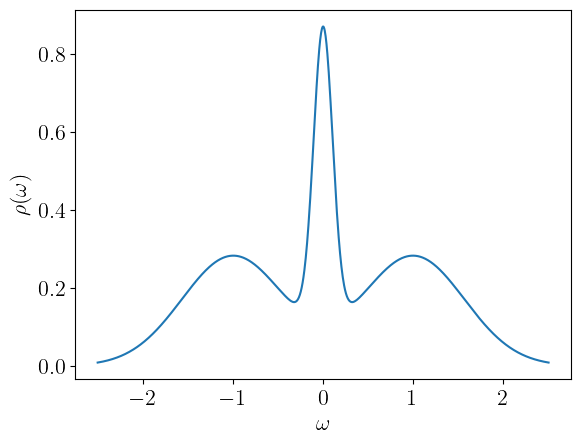

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/hiroshi/.julia/packages/PyCall/BD546/src/numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1969f9250>

In [4]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2) / (sqrt(π)*sigma)
rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = range(-2.5, 2.5, length=1000)
plt.xlabel(L"$\omega$")
plt.ylabel(L"$\rho(\omega)$")
plt.plot(omegas, rho.(omegas))

## Imaginary-time Green's function

We transform the spectral function to the Green's function using
$$
G(\tau) = - \int_{-\omega_\mathrm{max}}^{\omega_\mathrm{max}}d\tau K(\tau, \omega) \rho(\omega),
$$
where
$$
K(\tau, \omega) = \frac{e^{-\tau\omega}}{1+e^{-\beta\omega}}.
$$

When we discretize the kernel on uniform meshs for $\tau$ and $\omega$,
we obtain
$$
G(\tau_i) = - \frac{2\omega_\mathrm{max}}{N_\omega} \sum_j K(\tau_i, \omega_j) \rho(\omega_j) 
$$
for $i=1,2,\cdots,N_\tau$ and $j=1,2,\cdots,N_\omega$.
The cut-off frequency $\omega_\mathrm{max}$ must be large enough.
In this example, we use $\omega_\mathrm{max}=10$.

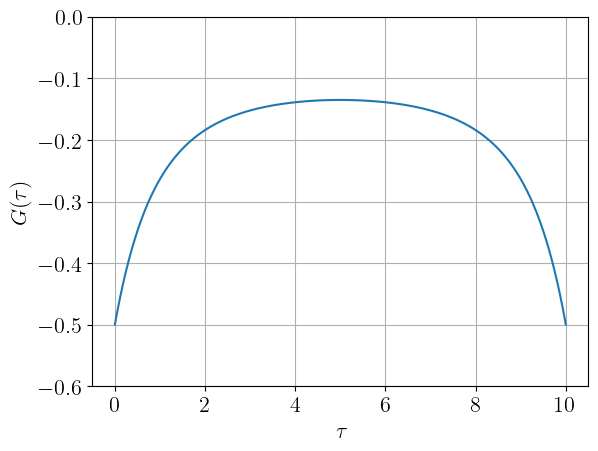

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x196a35730>

In [5]:
wmax = 10.0
beta = 10.0

nomega = 1000
ntau = 1000

omegas_mesh = collect(range(-wmax, wmax, length=nomega))
taus_mesh = collect(range(0, beta, length=ntau))

kernel(tau, omega) = exp(-tau*omega)/(1 + exp(-beta*omega))

kernel_val = kernel.(taus_mesh[:,newaxis], omegas_mesh[newaxis,:])
gtau = - kernel_val * rho.(omegas_mesh) * (2*wmax/nomega)

plt.xlabel(L"$\tau$")
plt.ylabel(L"$G(\tau)$")
plt.ylim([-0.6,0])
plt.grid()
plt.plot(taus_mesh, gtau)

In [6]:
print(gtau[1])

-0.4994999999999999

## Reconstruction of spectral function

Can we reconstruct the original $\rho(\omega)$?
You might use
$$
\rho(\omega_j) = - \frac{N_\omega}{2\omega_\mathrm{max}} \sum_i (K^{-1})_{ji} G(\tau_j)
$$

.

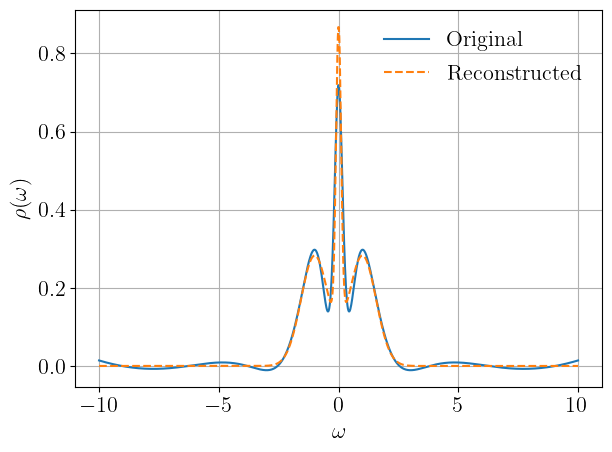

In [7]:
# OK, you get random data... (We actually used the pseudo inverse)
using LinearAlgebra
rho_reconst = -  (nomega/(2*wmax)) * (pinv(kernel_val, rtol=1e-3) * gtau)
plt.plot(omegas_mesh, rho_reconst, label="Original")
plt.plot(omegas_mesh, rho.(omegas_mesh), ls="--", label="Reconstructed")
plt.xlabel(L"$\omega$")
plt.grid()
plt.ylabel(L"$\rho(\omega)$")
plt.tight_layout()
plt.legend(loc="best", frameon=false)
plt.savefig("three_gaussian_julia.pdf", transparent=true)
;

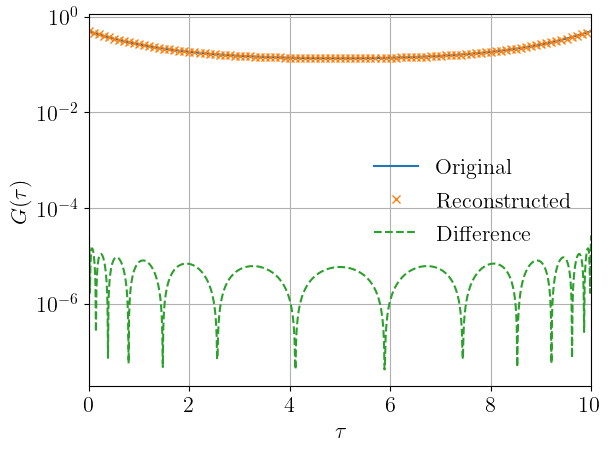

In [8]:
gtau_reconst = - (kernel_val * rho_reconst) * (2*wmax/nomega)

plt.xlabel(L"$\tau$")
plt.ylabel(L"$G(\tau)$")
plt.xlim([0,beta])
plt.grid()
plt.plot(taus_mesh, -gtau, label="Original")
plt.plot(taus_mesh[1:10:end], -gtau_reconst[1:10:end], label="Reconstructed", ls="", marker="x")
plt.plot(taus_mesh, abs.(gtau-gtau_reconst), ls="--", marker="", label="Difference")
plt.legend(loc="best", frameon=false)
plt.yscale("log")
plt.tight_layout()
plt.savefig("three_gaussian_gtau_julia.pdf", transparent=true)

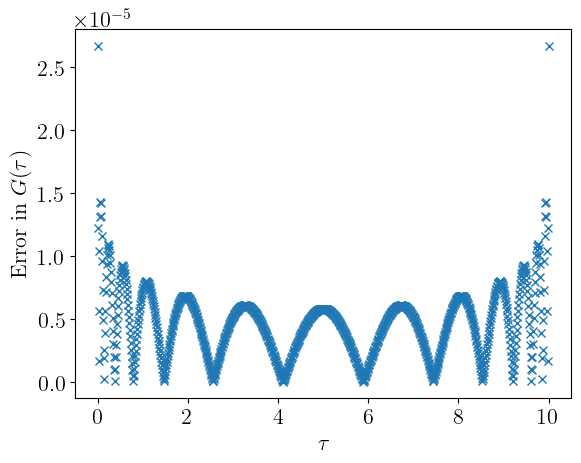

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1a2b1c430>

In [9]:
plt.xlabel(L"$\tau$")
plt.ylabel(L"Error in $G(\tau)$")
plt.plot(taus_mesh, abs.(gtau-gtau_reconst), ls="", marker="x")

## Singular values

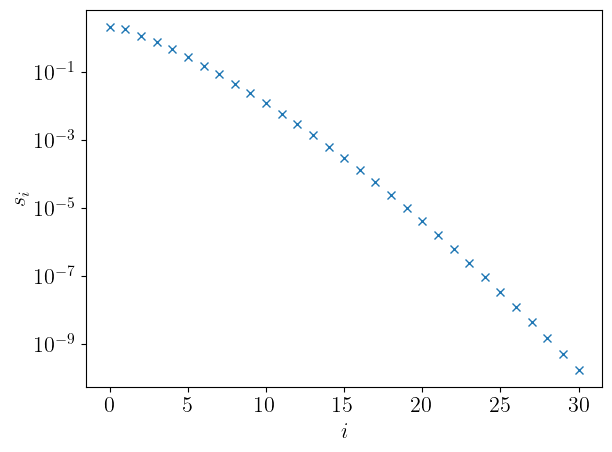

In [10]:
K = kernel_val * (2*wmax/nomega)
F = svd(K)
u, s, vh = F.U, F.S, F.Vt 
plt.ylabel(L"$s_i$")
plt.xlabel(L"$i$")
plt.semilogy(s[1:31], ls="", marker="x")
plt.tight_layout()
plt.savefig("kf_singular_vals_julia.pdf", transparent=true)

## Singular vectors

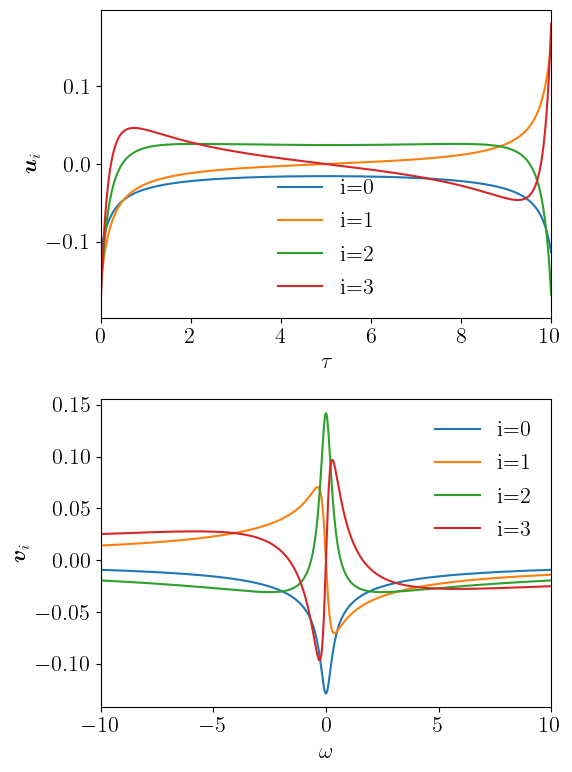

In [11]:
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axes = [ax1, ax2]

for i in 1:4
    ax1.plot(taus_mesh, u[:,i], label="i=$(i-1)")
    ax2.plot(omegas_mesh, vh[i,:], label="i=$(i-1)")
end

ax1.set_xlabel(L"$\tau$")
ax2.set_xlabel(L"$\omega$")
ax1.set_ylabel(L"$\boldsymbol{u}_i$")
ax2.set_ylabel(L"$\boldsymbol{v}_i$")
ax1.set_xlim([0,beta])
ax2.set_xlim([-wmax, wmax])

ax1.legend(loc="best", frameon=false)
ax2.legend(loc="best", frameon=false)
plt.tight_layout()
plt.savefig("kf_singular_vectors_julia.pdf", transparent=true)

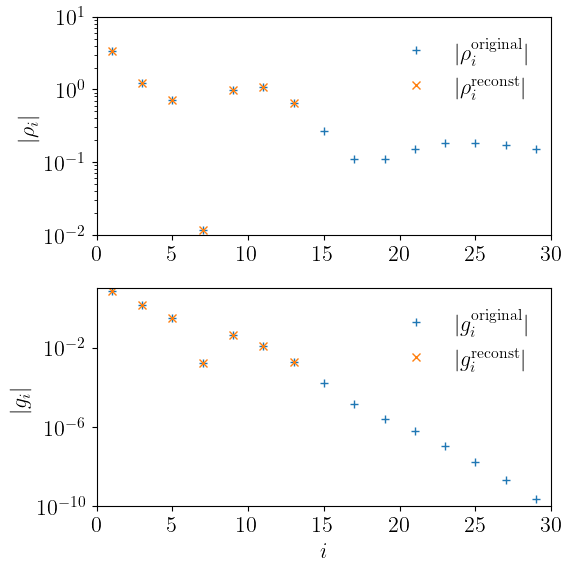

In [12]:
fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
axes = [ax1, ax2]

rhoi = vh * rho.(omegas_mesh)
rhoi_reconst = vh * rho_reconst
gi = transpose(u) * gtau
gi_reconst = transpose(u) * gtau_reconst

ax2.set_xlabel(L"$i$")
ax1.set_ylabel(L"$|\rho_i|$")
ax2.set_ylabel(L"$|g_i|$")

x = collect(1:length(rhoi))
ax1.semilogy(x[1:2:end], abs.(rhoi)[1:2:end], ls="", marker="+", label=L"$|\rho^\mathrm{original}_i|$")
ax1.semilogy(x[1:2:end], abs.(rhoi_reconst)[1:2:end], ls="", marker="x", label=L"$|\rho^\mathrm{reconst}_i|$")
ax2.semilogy(x[1:2:end], abs.(gi)[1:2:end], ls="", marker="+", label=L"$|g^\mathrm{original}_i|$")
ax2.semilogy(x[1:2:end], abs.(gi_reconst)[1:2:end], ls="", marker="x", label=L"$|g^\mathrm{reconst}_i|$")
ax1.set_xlim([0,30])
ax1.set_ylim([1e-10,10])
ax1.set_ylim([1e-2,10])
ax2.set_ylim([1e-10,10])
ax1.legend(loc="best", frameon=false)
ax2.legend(loc="best", frameon=false)
plt.tight_layout()
plt.savefig("gi_rhoi.pdf", transparent=true)

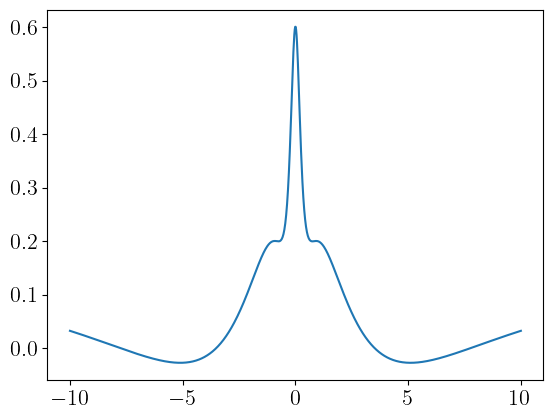

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x1a2ee16a0>

In [13]:
# Hint for Exercise
# We want to reconstruct rho(omega) from the first 10 SVD components
num_comp = 10
plt.plot(omegas_mesh, vec(rhoi[newaxis,1:num_comp]*vh[1:num_comp,:]))